### requirements / ToDo
[x]  train/test accuracy total + Fizz/Buzz/FizzBuzz separately    
[x]  graphs for different hyperparameter options (do graphs)    
[x]  try different learning algorithms    
[ ]  include best setting in report    
[x]  add main.py that creates output.csv    

## Logic Based FizzBuzz Function [Software 1.0]

In [1]:
!pip install tqdm hyperopt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
%matplotlib inline

set_random_seed(574)
np.random.seed(574)

/home/wolterlw/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def fizzbuzz(n):
    # Logic Explanation
    if n % 3 == 0 and n % 5 == 0:
        return 'fizzbuzz'
    elif n % 3 == 0:
        return 'fizz'
    elif n % 5 == 0:
        return 'buzz'
    else:
        return 'other'

## Create Training and Testing Datasets in CSV Format

In [4]:
def createInputCSV(start,end,filename):
    
    # Why list in Python?
    inputData   = []
    outputData  = []
    
    # Why do we need training Data?
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Why Dataframe?
    dataset = {}
    dataset["input"]  = inputData
    dataset["label"] = outputData
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename, index=False)
    
    print(filename, "Created!")

## Processing Input and Label Data

In [5]:
def processData(dataset):
    
    # Why do we have to process?
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel

In [6]:
def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10?
        # to encode digits from 1 to 1000
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    return np.array(processedData)

In [7]:
from keras.utils import np_utils

def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "fizzbuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4)

Using TensorFlow backend.


## Model Definition

In [150]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, SGD, Adam, Nadam

optimizers = {
    'SGD': SGD,
    'RMSprop': RMSprop,
    'Adam': Adam,
    'Nadam': Nadam
}

input_size = 10
output_size = 4

def get_model(params, verbose=False, optim_algo='RMSprop'):
    
    # Why do we need a model?
    # For it to learn the mapping from input to output
    
    # Why use Dense layer and then activation?
    # Dense layers contain the model coeficients that perform linear transformations on the input data
    # Activations are needed to introduce nonliniarities (composition of multiple linear transformation is just another linear transformation)
    
    # Why use sequential model with layers?
    # Because there is no need to use functional API as we have a linear computation graph
    
    assert len(params['hidden_layer_nodes']) == params['num_hidden'], "specify layer size for each hidden layer"
    
    model = Sequential()
    
    model.add(Dense(params['hidden_layer_nodes'][0], input_dim=input_size))
    model.add(Activation(params['activation']))
    # Why dropout?
    # to avoid overfitting (avoiding nodes that don't compute anything useful)
    model.add(Dropout(params['drop_out']))
    
    for i in range(1,params['num_hidden']):
        model.add(Dense(params['hidden_layer_nodes'][i]))
        model.add(Activation(params['activation']))
        model.add(Dropout(params['drop_out']))
    
    model.add(Dense(output_size))
    model.add(Activation('softmax'))
    # Why Softmax?
    # to get probabilistic output
    if verbose:
        model.summary()
    
    # Why use categorical_crossentropy?
    # because it's differentiable generalization of logloss that works for n-dimensional probabilistic outputs
    optimizer = optimizers[optim_algo](lr = params['learning_rate'])
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# <font color='blue'>Creating Training and Testing Datafiles</font>

In [151]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


# <font color='blue'>Creating Model</font>

In [162]:
hyper_params = {
    'drop_out':  0.339,
    'hidden_layer_nodes': [245, 154, 67],
    'num_hidden': 3,
    'activation': 'selu',
    'learning_rate': 0.00815
}

In [163]:
model = get_model(hyper_params, optim_algo='SGD')

# <font color = blue>Run Model</font>

In [164]:
validation_data_split = 0.2
num_epochs = 1000
model_batch_size = 128
early_patience = 100

earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=0, patience=early_patience, mode='min')

# Read Dataset
dataset = pd.read_csv('training.csv')

# Process Dataset
processedData, processedLabel = processData(dataset)
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [earlystopping_cb]
                   )

Train on 720 samples, validate on 180 samples
Epoch 1/1000
720/720 [==============================] - 6s 9ms/step - loss: 1.6283 - acc: 0.3236 - val_loss: 1.2006 - val_acc: 0.5333
Epoch 2/1000
720/720 [==============================] - 0s 124us/step - loss: 1.4782 - acc: 0.3875 - val_loss: 1.2275 - val_acc: 0.5333
Epoch 3/1000
720/720 [==============================] - 0s 139us/step - loss: 1.4422 - acc: 0.4222 - val_loss: 1.2001 - val_acc: 0.5333
Epoch 4/1000
720/720 [==============================] - 0s 128us/step - loss: 1.3927 - acc: 0.4208 - val_loss: 1.2091 - val_acc: 0.5333
Epoch 5/1000
720/720 [==============================] - 0s 119us/step - loss: 1.3788 - acc: 0.4347 - val_loss: 1.2115 - val_acc: 0.5333
Epoch 6/1000
720/720 [==============================] - 0s 103us/step - loss: 1.3805 - acc: 0.4431 - val_loss: 1.2186 - val_acc: 0.5333
Epoch 7/1000
720/720 [==============================] - 0s 111us/step - loss: 1.3525 - acc: 0.4472 - val_loss: 1.1937 - val_acc: 0.5333
Epoc

720/720 [==============================] - 0s 106us/step - loss: 1.2599 - acc: 0.4542 - val_loss: 1.1630 - val_acc: 0.5333
Epoch 61/1000
720/720 [==============================] - 0s 127us/step - loss: 1.2085 - acc: 0.4931 - val_loss: 1.1652 - val_acc: 0.5333
Epoch 62/1000
720/720 [==============================] - 0s 112us/step - loss: 1.2745 - acc: 0.4611 - val_loss: 1.1650 - val_acc: 0.5333
Epoch 63/1000
720/720 [==============================] - 0s 135us/step - loss: 1.2308 - acc: 0.4667 - val_loss: 1.1657 - val_acc: 0.5333
Epoch 64/1000
720/720 [==============================] - 0s 129us/step - loss: 1.2431 - acc: 0.4875 - val_loss: 1.1644 - val_acc: 0.5333
Epoch 65/1000
720/720 [==============================] - 0s 115us/step - loss: 1.2487 - acc: 0.4736 - val_loss: 1.1626 - val_acc: 0.5333
Epoch 66/1000
720/720 [==============================] - 0s 111us/step - loss: 1.2296 - acc: 0.4972 - val_loss: 1.1656 - val_acc: 0.5333
Epoch 67/1000
720/720 [==============================] 

Epoch 120/1000
720/720 [==============================] - 0s 112us/step - loss: 1.2006 - acc: 0.4972 - val_loss: 1.1527 - val_acc: 0.5333
Epoch 121/1000
720/720 [==============================] - 0s 130us/step - loss: 1.1960 - acc: 0.4931 - val_loss: 1.1532 - val_acc: 0.5333
Epoch 122/1000
720/720 [==============================] - ETA: 0s - loss: 1.2068 - acc: 0.492 - 0s 141us/step - loss: 1.2021 - acc: 0.4986 - val_loss: 1.1535 - val_acc: 0.5333
Epoch 123/1000
720/720 [==============================] - 0s 134us/step - loss: 1.2050 - acc: 0.5028 - val_loss: 1.1528 - val_acc: 0.5333
Epoch 124/1000
720/720 [==============================] - 0s 111us/step - loss: 1.1819 - acc: 0.5056 - val_loss: 1.1537 - val_acc: 0.5333
Epoch 125/1000
720/720 [==============================] - 0s 105us/step - loss: 1.1998 - acc: 0.4972 - val_loss: 1.1531 - val_acc: 0.5333
Epoch 126/1000
720/720 [==============================] - 0s 119us/step - loss: 1.1991 - acc: 0.5028 - val_loss: 1.1527 - val_acc: 0.5

720/720 [==============================] - 0s 135us/step - loss: 1.1745 - acc: 0.5097 - val_loss: 1.1496 - val_acc: 0.5333
Epoch 180/1000
720/720 [==============================] - 0s 100us/step - loss: 1.1704 - acc: 0.5306 - val_loss: 1.1485 - val_acc: 0.5333
Epoch 181/1000
720/720 [==============================] - 0s 117us/step - loss: 1.1890 - acc: 0.5139 - val_loss: 1.1497 - val_acc: 0.5333
Epoch 182/1000
720/720 [==============================] - 0s 155us/step - loss: 1.1786 - acc: 0.5167 - val_loss: 1.1487 - val_acc: 0.5333
Epoch 183/1000
720/720 [==============================] - 0s 122us/step - loss: 1.1906 - acc: 0.5208 - val_loss: 1.1491 - val_acc: 0.5333
Epoch 184/1000
720/720 [==============================] - 0s 141us/step - loss: 1.1886 - acc: 0.5250 - val_loss: 1.1489 - val_acc: 0.5333
Epoch 185/1000
720/720 [==============================] - 0s 125us/step - loss: 1.1714 - acc: 0.5167 - val_loss: 1.1489 - val_acc: 0.5333
Epoch 186/1000
720/720 [=========================

720/720 [==============================] - 0s 111us/step - loss: 1.1737 - acc: 0.5292 - val_loss: 1.1465 - val_acc: 0.5333
Epoch 239/1000
720/720 [==============================] - 0s 112us/step - loss: 1.1721 - acc: 0.5208 - val_loss: 1.1465 - val_acc: 0.5333
Epoch 240/1000
720/720 [==============================] - 0s 96us/step - loss: 1.1678 - acc: 0.5208 - val_loss: 1.1459 - val_acc: 0.5333
Epoch 241/1000
720/720 [==============================] - 0s 90us/step - loss: 1.1796 - acc: 0.5333 - val_loss: 1.1463 - val_acc: 0.5333
Epoch 242/1000
720/720 [==============================] - 0s 100us/step - loss: 1.1678 - acc: 0.5278 - val_loss: 1.1462 - val_acc: 0.5333
Epoch 243/1000
720/720 [==============================] - 0s 96us/step - loss: 1.1487 - acc: 0.5306 - val_loss: 1.1466 - val_acc: 0.5333
Epoch 244/1000
720/720 [==============================] - 0s 96us/step - loss: 1.1768 - acc: 0.5292 - val_loss: 1.1470 - val_acc: 0.5333
Epoch 245/1000
720/720 [=============================

720/720 [==============================] - 0s 149us/step - loss: 1.1736 - acc: 0.5319 - val_loss: 1.1444 - val_acc: 0.5333
Epoch 298/1000
720/720 [==============================] - 0s 154us/step - loss: 1.1697 - acc: 0.5347 - val_loss: 1.1446 - val_acc: 0.5333
Epoch 299/1000
720/720 [==============================] - 0s 115us/step - loss: 1.1592 - acc: 0.5278 - val_loss: 1.1446 - val_acc: 0.5333
Epoch 300/1000
720/720 [==============================] - 0s 108us/step - loss: 1.1618 - acc: 0.5306 - val_loss: 1.1444 - val_acc: 0.5333
Epoch 301/1000
720/720 [==============================] - 0s 96us/step - loss: 1.1509 - acc: 0.5347 - val_loss: 1.1443 - val_acc: 0.5333
Epoch 302/1000
720/720 [==============================] - 0s 98us/step - loss: 1.1609 - acc: 0.5319 - val_loss: 1.1443 - val_acc: 0.5333
Epoch 303/1000
720/720 [==============================] - 0s 124us/step - loss: 1.1818 - acc: 0.5333 - val_loss: 1.1439 - val_acc: 0.5333
Epoch 304/1000
720/720 [===========================

720/720 [==============================] - 0s 117us/step - loss: 1.1612 - acc: 0.5333 - val_loss: 1.1439 - val_acc: 0.5333
Epoch 357/1000
720/720 [==============================] - 0s 103us/step - loss: 1.1431 - acc: 0.5306 - val_loss: 1.1439 - val_acc: 0.5333
Epoch 358/1000
720/720 [==============================] - 0s 112us/step - loss: 1.1540 - acc: 0.5333 - val_loss: 1.1437 - val_acc: 0.5333
Epoch 359/1000
720/720 [==============================] - 0s 106us/step - loss: 1.1520 - acc: 0.5347 - val_loss: 1.1436 - val_acc: 0.5333
Epoch 360/1000
720/720 [==============================] - 0s 96us/step - loss: 1.1578 - acc: 0.5333 - val_loss: 1.1437 - val_acc: 0.5333
Epoch 361/1000
720/720 [==============================] - 0s 98us/step - loss: 1.1606 - acc: 0.5292 - val_loss: 1.1433 - val_acc: 0.5333
Epoch 362/1000
720/720 [==============================] - 0s 94us/step - loss: 1.1407 - acc: 0.5333 - val_loss: 1.1431 - val_acc: 0.5333
Epoch 363/1000
720/720 [============================

720/720 [==============================] - 0s 101us/step - loss: 1.1522 - acc: 0.5333 - val_loss: 1.1418 - val_acc: 0.5333
Epoch 416/1000
720/720 [==============================] - 0s 108us/step - loss: 1.1458 - acc: 0.5319 - val_loss: 1.1419 - val_acc: 0.5333
Epoch 417/1000
720/720 [==============================] - 0s 107us/step - loss: 1.1621 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 418/1000
720/720 [==============================] - 0s 100us/step - loss: 1.1434 - acc: 0.5347 - val_loss: 1.1419 - val_acc: 0.5333
Epoch 419/1000
720/720 [==============================] - 0s 92us/step - loss: 1.1529 - acc: 0.5333 - val_loss: 1.1419 - val_acc: 0.5333
Epoch 420/1000
720/720 [==============================] - 0s 97us/step - loss: 1.1547 - acc: 0.5333 - val_loss: 1.1419 - val_acc: 0.5333
Epoch 421/1000
720/720 [==============================] - 0s 102us/step - loss: 1.1623 - acc: 0.5333 - val_loss: 1.1419 - val_acc: 0.5333
Epoch 422/1000
720/720 [===========================

720/720 [==============================] - 0s 106us/step - loss: 1.1551 - acc: 0.5333 - val_loss: 1.1416 - val_acc: 0.5333
Epoch 475/1000
720/720 [==============================] - 0s 107us/step - loss: 1.1498 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 476/1000
720/720 [==============================] - 0s 95us/step - loss: 1.1399 - acc: 0.5333 - val_loss: 1.1418 - val_acc: 0.5333
Epoch 477/1000
720/720 [==============================] - 0s 99us/step - loss: 1.1618 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 478/1000
720/720 [==============================] - 0s 98us/step - loss: 1.1410 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 479/1000
720/720 [==============================] - 0s 119us/step - loss: 1.1597 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 480/1000
720/720 [==============================] - 0s 151us/step - loss: 1.1468 - acc: 0.5333 - val_loss: 1.1418 - val_acc: 0.5333
Epoch 481/1000
720/720 [============================

720/720 [==============================] - 0s 132us/step - loss: 1.1514 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 534/1000
720/720 [==============================] - 0s 157us/step - loss: 1.1470 - acc: 0.5333 - val_loss: 1.1416 - val_acc: 0.5333
Epoch 535/1000
720/720 [==============================] - 0s 125us/step - loss: 1.1544 - acc: 0.5333 - val_loss: 1.1416 - val_acc: 0.5333
Epoch 536/1000
720/720 [==============================] - 0s 122us/step - loss: 1.1408 - acc: 0.5333 - val_loss: 1.1416 - val_acc: 0.5333
Epoch 537/1000
720/720 [==============================] - 0s 126us/step - loss: 1.1575 - acc: 0.5333 - val_loss: 1.1416 - val_acc: 0.5333
Epoch 538/1000
720/720 [==============================] - 0s 122us/step - loss: 1.1526 - acc: 0.5333 - val_loss: 1.1416 - val_acc: 0.5333
Epoch 539/1000
720/720 [==============================] - 0s 117us/step - loss: 1.1435 - acc: 0.5333 - val_loss: 1.1417 - val_acc: 0.5333
Epoch 540/1000
720/720 [=========================

In [165]:
from hyperopt import hp, STATUS_OK, tpe, fmin, Trials
from hyperopt.pyll.stochastic import sample

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
ITERATION = 0

def hypp_search_objective(hypp):
    global ITERATION
    ITERATION += 1
    
    hypp.update(hypp.pop('num_hidden'))
    hypp['hidden_layer_nodes'] = [int(x) for x in hypp['hidden_layer_nodes']]
    
    model = get_model(hypp)
    
    history = model.fit(processedData
                    , processedLabel
                    , validation_split = validation_data_split
                    , epochs = num_epochs
                    , batch_size = model_batch_size
                    , callbacks = [earlystopping_cb]
                    , verbose = False
                   )
    best_acc = np.max(history.history['val_acc'])
    train_acc = np.max(history.history['acc'])
    loss = 1 - best_acc
    
    return {'loss': loss, 'best_acc': best_acc, 'train_acc': train_acc,
            'params': hypp, 'iteration': ITERATION, 'status': STATUS_OK}

def class_accuracy(pred_score, y_true):
    
    
    CM = confusion_matrix(
        np.argmax(y_true,axis=1),
        np.argmax(pred_score,axis=1)
    )
    return np.diagonal(CM / CM.sum(axis=1))

def model_test(model,data):
    
    hist = model.fit(data['X_tr'],
              data['y_tr'],
              validation_split = 0.2,
              epochs = num_epochs,
              batch_size = model_batch_size,
              callbacks = [earlystopping_cb],
              verbose = False)
    
    pred_train = model.predict(data['X_tr'])
    pred_test = model.predict(data['X_ts'])
    
    return {
        'train': class_accuracy(data['y_tr'], pred_train),
        'test': class_accuracy(data['y_ts'], pred_test),
        'hist': hist
    }

### domain space

In [26]:
space = {
    'activation': hp.choice('activation', ['tanh', 'relu', 'elu', 'selu']),
    'num_hidden': hp.choice('num_hidden', [{'num_hidden': 1, 'hidden_layer_nodes': [hp.qnormal('hidden_11_size', 256, 10, 1)]}, 
                                           {'num_hidden': 2, 'hidden_layer_nodes': [hp.qnormal('hidden_12_size', 256, 10, 1), hp.qnormal('hidden_22_size', 128, 10, 1)]},
                                           {'num_hidden': 3, 'hidden_layer_nodes': [hp.qnormal('hidden_13_size', 256, 10, 1), hp.qnormal('hidden_23_size', 128, 10, 1), hp.qnormal('hidden_2_size', 64, 5, 1)]}]),
    'drop_out': hp.uniform('drop_out', 0.0, 0.9),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)) #more frequent sampling for smaller values
}

In [27]:
bayes_trials = Trials()

In [28]:
best = fmin(fn = hypp_search_objective, space = space, algo = tpe.suggest,
            max_evals = 5, trials = bayes_trials, rstate = np.random.RandomState(573))

In [29]:
max(bayes_trials.trials, key=lambda x: x['result']['best_acc'])

{'book_time': datetime.datetime(2018, 9, 16, 18, 33, 4, 593000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'activation': [2],
   'drop_out': [2],
   'hidden_11_size': [],
   'hidden_12_size': [2],
   'hidden_13_size': [],
   'hidden_22_size': [2],
   'hidden_23_size': [],
   'hidden_2_size': [],
   'learning_rate': [2],
   'num_hidden': [2]},
  'tid': 2,
  'vals': {'activation': [3],
   'drop_out': [0.14026717737669409],
   'hidden_11_size': [],
   'hidden_12_size': [257.0],
   'hidden_13_size': [],
   'hidden_22_size': [122.0],
   'hidden_23_size': [],
   'hidden_2_size': [],
   'learning_rate': [0.0012242704296310323],
   'num_hidden': [1]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2018, 9, 16, 18, 33, 42, 811000),
 'result': {'best_acc': 0.9444444497426351,
  'iteration': 3,
  'loss': 0.055555550257364916,
  'params': {'activation': 'selu',
   'drop_out': 0.14026717737669409,
   'hidden_layer_nodes': [257, 1

### using Google Colaboratory found that
```
{
    'drop_out':  0.339,
    'hidden_layer_nodes': [245, 154, 67],
    'num_hidden': 3,
    'activation': 'tanh',
    'learning_rate': 0.00815
}```
is the best option

### how train and test scores depend on Dropout and learning algorithm

In [30]:
params = {
    'hidden_layer_nodes': [245, 154, 67],
    'num_hidden': 3,
    'activation': 'tanh',
    'learning_rate': 0.00815,
    'drop_out': 0.339
}

In [31]:
data_train = pd.read_csv('./training.csv')
data_test = pd.read_csv('./testing.csv')

X_tr, y_tr = processData(data_train)
X_ts, y_ts = processData(data_test)

data = {
    'X_tr': X_tr,
    'X_ts': X_ts,
    'y_tr': y_tr,
    'y_ts': y_ts
}

In [32]:
model = get_model(params)
model.save_weights('./init_weights.hdf5')

In [33]:
from tqdm import tqdm_notebook as tqdm

In [73]:
dropout_test = []

params_wo_dropout = params.copy()
del params_wo_dropout['drop_out']

for dropout in tqdm(np.linspace(0,0.9,num=20)):
    model = get_model(dict({'drop_out': dropout}, **params_wo_dropout))
    model.load_weights('./init_weights.hdf5')
    dropout_test.append(
        model_test(model, data)   
    )

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

/home/wolterlw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/home/wolterlw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


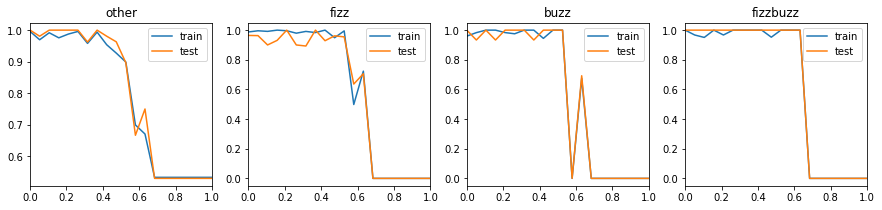

In [74]:
dropout_test = {
    'test': np.r_[[x['test'] for x in dropout_test]],
    'train': np.r_[[x['train'] for x in dropout_test]]
}

cols = ['other', 'fizz', 'buzz', 'fizzbuzz']
index = np.linspace(0,1,20)

do_train = pd.DataFrame(dropout_test['train'],columns=cols, index=index).fillna(0)
do_test = pd.DataFrame(dropout_test['test'],columns=cols, index=index).fillna(0)

f,ax = plt.subplots(1,4,figsize=(15,3))

for i,c in enumerate(cols):
    ax[i].set_title(c)
    do_train[c].plot(label='train', ax=ax[i])
    do_test[c].plot(label='test', ax=ax[i])
    ax[i].legend()

In [61]:
algo_test = []

for algo in tqdm(['SGD','RMSprop','Adam','Nadam']):
    model = get_model(params, optim_algo=algo)
    model.load_weights('./init_weights.hdf5')
    algo_test.append(
        model_test(model, data)   
    )

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

/home/wolterlw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/home/wolterlw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
algo_test = {
    'test': np.r_[[x['test'] for x in algo_test]],
    'train': np.r_[[x['train'] for x in algo_test]],
    'epochs_train': np.r_[[len(x['hist'].history['acc']) for x in algo_test]]
}

cols = ['other', 'fizz', 'buzz', 'fizzbuzz']
index = ['SGD','RMSprop','Adam','Nadam']

algo_train = pd.DataFrame(algo_test['train'],columns=cols, index=index).fillna(0)
algo_train['n_epochs'] = algo_test['epochs_train']
algo_test = pd.DataFrame(algo_test['test'],columns=cols, index=index).fillna(0)

In [67]:
algo_test.columns = [x+'_test' for x in algo_test.columns]

In [79]:
algo_train.drop('n_epochs',axis=1).mean(axis=1)

SGD        0.133333
RMSprop    0.986487
Adam       0.987118
Nadam      0.970924
dtype: float64

In [77]:
algo_test.mean(axis=1)

SGD        0.132500
RMSprop    1.000000
Adam       0.981125
Nadam      0.995370
dtype: float64

In [75]:
pd.concat([algo_test,algo_train],axis=1)

other_test  fizz_test  buzz_test  fizzbuzz_test     other      fizz  \
SGD        0.530000   0.000000        0.0            0.0  0.533333  0.000000   
RMSprop    1.000000   1.000000        1.0            1.0  0.987552  0.983122   
Adam       0.962963   0.961538        1.0            1.0  0.985507  0.962963   
Nadam      0.981481   1.000000        1.0            1.0  0.955645  1.000000   

             buzz  fizzbuzz  n_epochs  
SGD      0.000000  0.000000       108  
RMSprop  0.991667  0.983607       808  
Adam     1.000000  1.000000       858  
Nadam    0.944444  0.983607       690

### testing lower learning rate for SGD

In [99]:
params

{'activation': 'tanh',
 'drop_out': 0.339,
 'hidden_layer_nodes': [245, 154, 67],
 'learning_rate': 0.00815,
 'num_hidden': 3}

In [105]:
params_lr = params.copy()
params_lr['learning_rate'] = 1e-2

model = get_model(params_lr, optim_algo='SGD')
model.load_weights('./init_weights.hdf5')
res = model_test(model, data)

/home/wolterlw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/home/wolterlw/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


# <font color = blue>Training and Validation Graphs</font>

In [ ]:
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

# <font color = blue>Testing Accuracy [Software 2.0]</font>

In [ ]:
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "other"
    elif encodedLabel == 1:
        return "fizz"
    elif encodedLabel == 2:
        return "buzz"
    elif encodedLabel == 3:
        return "fizzbuzz"

In [ ]:
model = get_model(params)
model_test(model, data)

In [ ]:
wrong   = 0
right   = 0

testData = pd.read_csv('testing.csv')

processedTestData  = encodeData(testData['input'].values)
processedTestLabel = encodeLabel(testData['label'].values)
predictedTestLabel = []

for i,j in zip(processedTestData,processedTestLabel):
    y = model.predict(np.array(i).reshape(-1,10))
    predictedTestLabel.append(decodeLabel(y.argmax()))
    
    if j.argmax() == y.argmax():
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

output = {}
output["input"] = testData['input']
output["label"] = testData['label']
output["predicted_label"] = predictedTestLabel

opdf = pd.DataFrame(output)
opdf.to_csv('output.csv')